##### Here, we develop a model that takes the image embeddings as input and predicts the text embeddings. A CNN network was developed and finalized after several experiments with different set of NN layers.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Flatten, Dense
from tensorflow.keras.models import Model

2023-11-14 19:40:38.005858: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 19:40:38.318503: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf

def masked_mae_loss(y_true, y_pred):
    # Create a mask for non-padded elements (Assuming padding is done with zeros)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    
    # Calculate the Mean Absolute Error loss
    loss = tf.abs(y_true - y_pred)

    # Apply the mask to ignore padded elements
    loss *= mask

    # Calculate the mean loss considering only the non-padded elements
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss




In [3]:
#tf.keras.backend.clear_session()


In [4]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the input shape
input_shape = (28, 28, 512)  # As per your image embeddings

# Model architecture
input_layer = Input(shape=input_shape)

# Convolutional layer
x = Conv2D(512, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Flatten the output
x = Flatten()(x)

# Dense layers with Dropout
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)

# Output layer
output_layer = Dense(768, activation='linear')(x)  # Linear activation for regression

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Optimizer with a lower learning rate
optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_absolute_error')

# Model summary
model.summary()

2023-11-14 19:40:41.585020: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:4b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 19:40:41.765406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:4b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 19:40:41.765457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:4b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 19:40:41.772342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:4b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 19:40:41.772390: I tensorflow/compile

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 512)]     0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 512)       2359808   
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 512)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       1179904   
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         295040

r/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:4b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 19:40:42.874068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:4b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 19:40:42.874133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:4b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 19:40:42.874141: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1726] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2023-11-14 19:40:42.874170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to r

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor for improvement (validation loss)
    patience=35,  # Number of epochs with no improvement after which training will stop
    restore_best_weights=True  # Restore the model weights from the epoch with the best value of the monitored metric
)

In [6]:
import numpy as np
image_features = np.load('imgEmbeddingsB4C4.npy')

In [7]:
image_features[np.isnan(image_features)] = 0

In [8]:
import pickle
# Load the data from the pickle file
with open('text_embeddings.pkl', 'rb') as fin:
    data = pickle.load(fin)


In [9]:
text_embeddings = data

In [10]:
max_length = max(embedding.shape[0] for embedding in text_embeddings)
max_length

768

In [11]:
# Function to pad embeddings
def pad_embeddings(embeddings, max_length):
    padded_embeddings = []
    for embedding in embeddings:
        # Calculate padding length
        padding_length = max_length - embedding.shape[0]
        
        # Create padding (zero padding in this example)
        padding = np.zeros(padding_length)

        # Append padding to the embedding
        padded_embedding = np.append(embedding, padding)
        padded_embeddings.append(padded_embedding)

    return np.array(padded_embeddings)

# Apply padding
padded_embeddings = pad_embeddings(text_embeddings, max_length)

In [12]:
padded_embeddings.shape

(7470, 768)

In [13]:
# Fit the model
history = model.fit(image_features,
                    padded_embeddings,
                    epochs=600, 
                    batch_size=32,
                    validation_split = 0.2)


Epoch 1/600


2023-11-14 19:41:47.790563: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2023-11-14 19:41:49.604666: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-14 19:41:49.946307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-14 19:41:49.971025: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fec47880800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-14 19:41:49.971066: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2023-11-14 19:41:50.013056: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-14 19:41:5

187/187 [==============================] - 15s 35ms/step - loss: 0.1818 - val_loss: 0.1220
Epoch 2/600
187/187 [==============================] - 4s 21ms/step - loss: 0.1268 - val_loss: 0.1179
Epoch 3/600
187/187 [==============================] - 4s 22ms/step - loss: 0.1226 - val_loss: 0.1162
Epoch 4/600
187/187 [==============================] - 4s 21ms/step - loss: 0.1180 - val_loss: 0.1088
Epoch 5/600
187/187 [==============================] - 4s 21ms/step - loss: 0.1124 - val_loss: 0.1084
Epoch 6/600
187/187 [==============================] - 4s 21ms/step - loss: 0.1151 - val_loss: 0.1086
Epoch 7/600
187/187 [==============================] - 4s 21ms/step - loss: 0.1118 - val_loss: 0.1086
Epoch 8/600
187/187 [==============================] - 4s 21ms/step - loss: 0.1114 - val_loss: 0.1082
Epoch 9/600
187/187 [==============================] - 4s 21ms/step - loss: 0.1114 - val_loss: 0.1084
Epoch 10/600
187/187 [==============================] - 4s 21ms/step - loss: 0.1122 - val_los

In [14]:
# Check for NaNs
print("NaNs in image embeddings:", np.isnan(image_features).any())
print("NaNs in text embeddings:", np.isnan(padded_embeddings).any())

NaNs in image embeddings: False
NaNs in text embeddings: False


In [15]:
image_features[np.isnan(image_features)] = 0

In [16]:
print("NaNs in image embeddings:", np.isnan(image_features).any())

NaNs in image embeddings: False


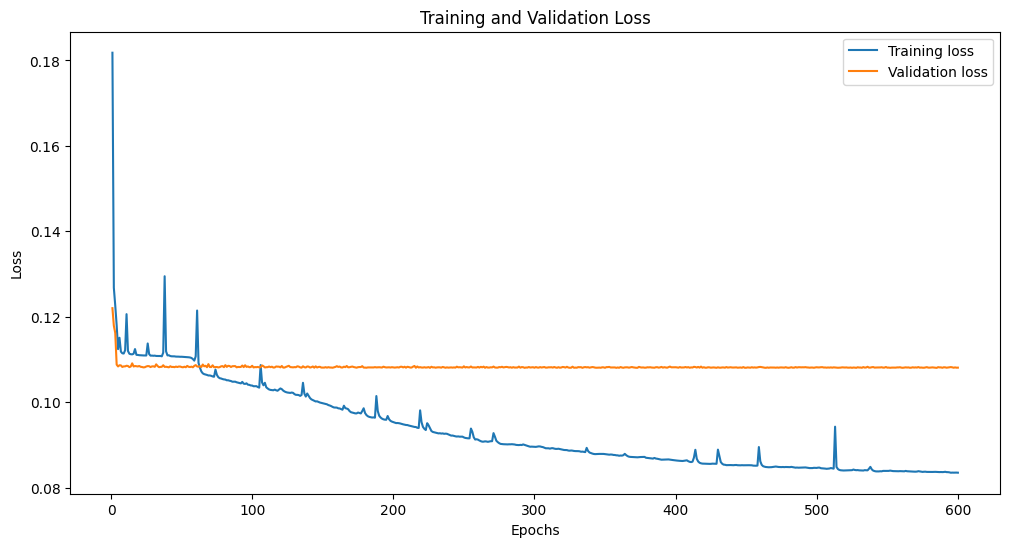

In [19]:
import matplotlib.pyplot as plt

# Extract loss and validation loss from history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range object for the number of epochs
epochs = range(1, len(loss) + 1)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [20]:
model.save('ImgEmb-To-TextEmb.h5')

/home/amoha108/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
